In [27]:
%pylab inline
style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [28]:
from neuron import h, gui

# Using original RM03 model and interface to NEURON

In [29]:
total_capacitance = 12 # pF

soma_area = total_capacitance * 1e-6 / 1 # pF -> uF, 1 uF/cm^2
soma_diam = 1e4*sqrt(soma_area/pi) # cm->um

print 'Soma area: %02.2e cm^2, diameter: %02.2f um'%(soma_area,soma_diam)
# Isn't it a bit too large a diameter? -> No, it's OK


Soma area: 1.20e-05 cm^2, diameter: 19.54 um


In [30]:
currents = ['klt', 'kht', 'na', 'ka', 'ih', 'hcno', 'leak']

In [31]:
def ns_to_mhocm2(x):
    "Convert from nanosiemens to siemens/cm^2"
    return 1e-9*x/soma_area

In [32]:

typeII = {cond:ns_to_mhocm2(val) for cond, val in 
 [('gnabar',1000), ('gkhtbar',150), ('gkltbar', 200),
  ('gabar', 0),  ('ghbar', 20),   ('glk', 2), ]}

typeII['glk'] = 0
typeII['Vm0'] = -63.6
# in S/cm^2
typeII

{'Vm0': -63.6,
 'gabar': 0.0,
 'ghbar': 0.0016666666666666666,
 'gkhtbar': 0.0125,
 'gkltbar': 0.016666666666666666,
 'glk': 0,
 'gnabar': 0.08333333333333334}

In [33]:
bushy = h.Section(name='bushy') 
bushy.nseg=1
bushy.diam = soma_diam
bushy.L = soma_diam
bushy.Ra = 150
bushy.cm = 1

In [34]:
for cur in currents:
    bushy.insert(cur)

In [35]:
bushy.ek = -70
bushy.ena = 50
bushy.gbar_hcno = 0

bushy.gnabar_na = typeII['gnabar']
bushy.gkhtbar_kht = typeII['gkhtbar']
bushy.gkltbar_klt = typeII['gkltbar']
bushy.gkabar_ka = typeII['gabar']
bushy.ghbar_ih = typeII['ghbar']
bushy.g_leak = typeII['glk']

In [36]:
h.psection(bushy)

1.0

In [37]:
v_vec = h.Vector()             # Membrane potential vector
t_vec = h.Vector()             # Time stamp vector
v_vec.record(bushy(0.5)._ref_v)
t_vec.record(h._ref_t)


1.0

In [38]:
h.v_init = typeII['Vm0']

In [39]:
h.tstop = 2000

In [40]:
h.run()

0.0

(-50, -70)

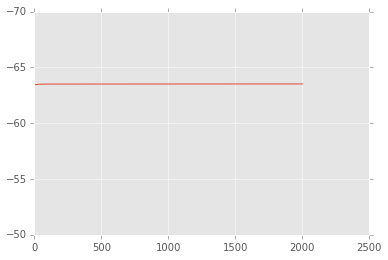

In [41]:
plot(t_vec, v_vec);
ylim(-50,-70)

In [42]:
bushy.v

-63.518161789521216

In [43]:
seg = bushy(0.5)

In [44]:
seg.ih.i*0.2 + seg.ina

-0.0010594020405146315

In [45]:
seg.ih.i*0.8 + seg.ik

0.0010594059638932415

In [46]:
gnar = seg.ina/(seg.v-seg.ena)  # Siemens/cm^2
gkr = seg.ik/(seg.v-seg.ek)
ghr = seg.i_ih/(seg.v- -43)
glkr = seg.leak.i/(seg.v -seg.erev_leak)


Rin_t2 = 71.0 # From Rothman and Manis 2003

# From model:
Ginx = (gnar + gkr + ghr + glkr)* seg.area()*1e-8
Rin_t2x = 1e-6/Ginx 

print Rin_t2, 'in cit., in model:', Rin_t2x, 'MOhm'

71.0 in cit., in model: 81.9637138282 MOhm


In [47]:
R = 8314.4  # Universal gaz constant, mJ / mole*K
F = 96485   # Faraday constant [C/mol]
F_ATP = 50 # kJ/mol

avogadro = 6.022e23 # N_a

In [48]:
def ratp_atwell(V, Rin, Ena = 50, Ek = -70):
    "returns resting ATP consumption rate in pmol ATP/s"
    # I take Rm in MOhms and V in mV
    # Thus, result is in nmole/sec
    out = (Ena-V)*(V-Ek)/(F*Rin*(V + 2*Ena - 3*Ek))
    return out*1e3 # nmol -> pmol

def pmol2molecules(x):
    return x*1e-12*avogadro

def atp2J(nATP):
    "Convert pmol ATP/s to energy usage in pJoule/s"
    return F_ATP * nATP * 1e3
    pas

def nJ2atp(nJ):
    "convert from nJoule/s to nmol ATP/s"
    return (nJ/F_ATP)*1e-3

## Оценка затрат в покое по Attwell и по Moujahid&D'Anjou

In [51]:
rATP_bushy  = ratp_atwell(bushy.v, Rin_t2x, Ek=-70)

print\
"""Оценка по Attwell: {:.3e} pmol ATP/сек
                 : {:.3e} pJ/s""".format(rATP_bushy, atp2J(rATP_bushy))

Оценка по Attwell: 3.775e-04 pmol ATP/сек
                 : 1.887e+01 pJ/s


In [65]:
def mouj_Erate(seg, erev_ih = -43):
    v = seg.v
    acc = 0
    acc += seg.ina*(v-seg.ena) 
    acc += seg.ik*(v-seg.ek)
    acc += seg.i_leak*(v-seg.erev_leak)
    acc += seg.ih.i*(v-erev_ih)
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

def hasegawa_Erate(seg, erev_ih = -43):
    v = seg.v
    acc = 0
    acc -= seg.ina*seg.ena 
    acc -= seg.ik*seg.ek
    acc -= seg.i_leak*seg.erev_leak
    acc -= seg.ih.i*erev_ih
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

In [66]:
dH_bushy2 = mouj_Erate(bushy(0.5))
dH_bushy3 = hasegawa_Erate(bushy(0.5))

rATP_bushy2 = nJ2atp(dH_bushy2)
rATP_bushy3 = nJ2atp(dH_bushy3)

In [67]:
print\
"""Оценка по Moujahid & D'Anjou: {:.3e} pmole ATP/сек
                            : {:.3e} pJ/s""".format(rATP_bushy2, dH_bushy2)

Оценка по Moujahid & D'Anjou: 3.408e-05 pmole ATP/сек
                            : 1.704e+00 pJ/s


In [100]:
print\
"""Оценка по Hasegawa: {:.3e} pmole ATP/сек
                  : {:.3e} pJ/s""".format(rATP_bushy3, dH_bushy3)

Оценка по Hasegawa: 3.408e-05 pmole ATP/сек
                  : 1.704e+00 pJ/s


Attwell to Moujahid ratio:

In [102]:
rATP_bushy/rATP_bushy2

11.077424614117765

In [107]:
jk = (bushy.ik + 0.8*seg.ih.i)*soma_area/F # mmol/s
jna = (bushy.ina + 0.2*seg.ih.i)*soma_area/F

## В текущей модели, получается, что jk=jna, что сложно совместимо
## со стехиометрией Na,K-АТФ-азы

print allclose(jk,jna)

jatp_na = -jna/3
jatp_k = jk/2


print jatp_na*1e9, 'pmol ATP/s [from jNa]'
print jatp_k*1e9, 'pmol ATP/s [from jK]'

True
4.39198648708e-05 pmol ATP/s [from jNa]
6.58800412848e-05 pmol ATP/s [from jK]


А это близко к тому, что дает оценка по Moujahid, но не по Attwell (хотя бы по порядку величин). Но почему?..

In [109]:
seg.ina

-6.885156002030318e-05